In [ ]:
import functions

import numpy as np
import pandas as pd
import importlib
from scipy.stats import pearsonr, spearmanr
from scipy.stats import linregress


importlib.reload(functions)

<module 'functions' from '/Users/maylismuller/Desktop/EPFL_DOCS/Master/MA4/Project Hummel/uphummel_MA4/functions.py'>

In [51]:

excel_folder_path = "data/"
FM_folder_path = "data/Raw_MissingDataImputed/"
regression_info, rsfMRI_full_info = functions.load_excel_data(excel_folder_path, FM_folder_path)
folder_path = "FC_matrices_times_wp11/"

rois = [363, 364, 365, 368, 372, 373, 374, 377, 379, 361, 370, 362, 371, 12, 54, 56, 78, 96, 192, 234, 236, 258, 276, 8, 9, 51, 52, 53, 188, 189, 231, 232, 233]
rois = [roi - 1 for roi in rois]
rois_sub = rois
rois_full = np.arange(0, 379)
selected_rois = [362, 363, 364, 367, 371, 372, 373, 376]

striatum_labels = [
    'Caudate_ipsi', 'Putamen_ipsi', 'Caudate_contra', 'Putamen_contra', 'Pallidum_ipsi', 'Pallidum_contra', 
    'Accumbens_ipsi', 'Accumbens_contra'
]
# Step 1: Filter regression info to T1 and matching conditions
regression_T1 = regression_info[
    (regression_info["TimePoint"] == "T3") &
    (regression_info["Behavioral_assessment"] == 1) &
    (regression_info["MRI"] == 1)
].copy()

Trying to load: TiMeS_matrix_mdImputed_allT4.xlsx
✅ Successfully loaded: TiMeS_matrix_mdImputed_allT4.xlsx
Trying to load: TiMeS_matrix_mdImputed_allT3.xlsx
✅ Successfully loaded: TiMeS_matrix_mdImputed_allT3.xlsx
Trying to load: TiMeS_matrix_mdImputed_allT2.xlsx
✅ Successfully loaded: TiMeS_matrix_mdImputed_allT2.xlsx
Trying to load: TiMeS_matrix_mdImputed_allT1.xlsx
✅ Successfully loaded: TiMeS_matrix_mdImputed_allT1.xlsx


In [3]:
all_matrices, all_subjects, yeo_mat_all_rois, roi_mapping_yeo = functions.load_matrices(folder_path, rsfMRI_full_info, rois, request_type='all', plot=False)
t1_t3_t4_matched = all_matrices.copy().dropna(subset=['T1_matrix', 'T3_matrix', 'T4_matrix'])

roi_mapping = functions.load_roi_labels("data/HCP-MMP1_RegionsCorticesList_379.csv")  # adapt path


df_aligned = functions.switch_contra_ipsi_df(
    t1_t3_t4_matched,  
    tp=3, 
    rois=rois,
    roi_mapping=roi_mapping
)

df_aligned = df_aligned.merge(t1_t3_t4_matched[['subject_id', 'Lesion_side']], on='subject_id', how='left')

# T3 whole group

## fmi pearson

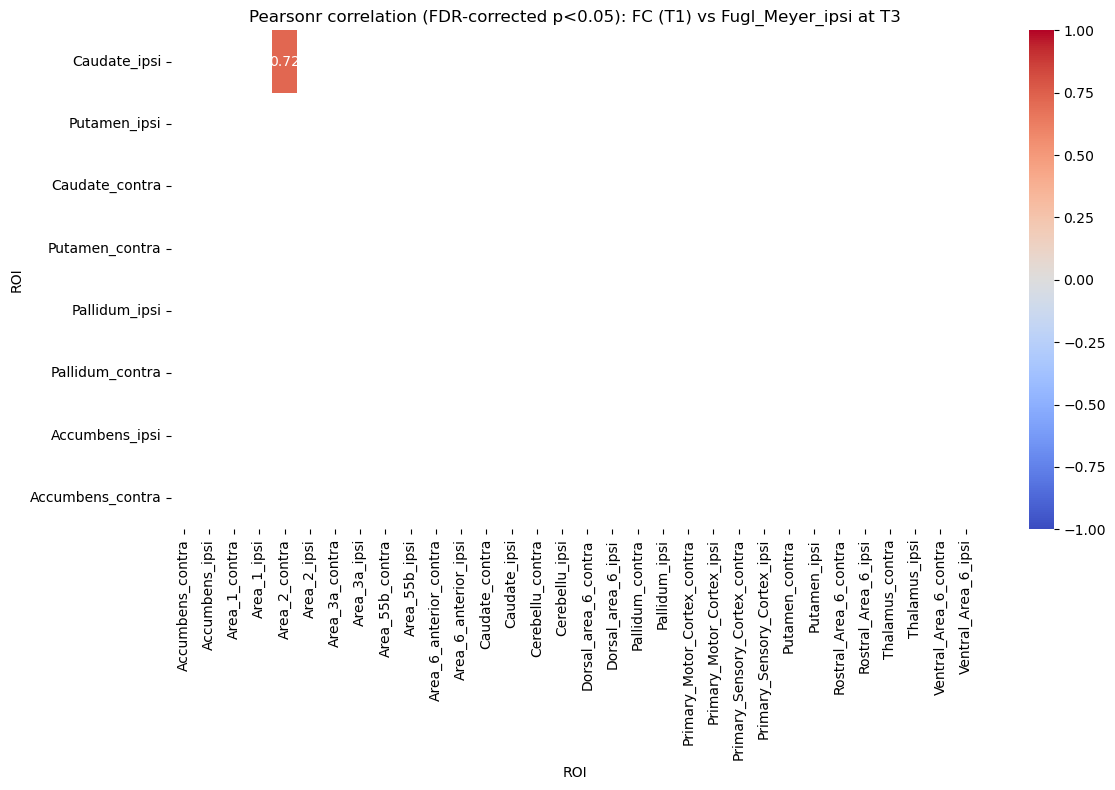

array([ 0.        ,  0.        , -0.04087308, -0.02397352, -0.11887125,
       -0.09904364,  0.09684104,  0.07744116,  0.19919499,  0.132201  ,
       -0.15690909,  0.16817379,  0.12554258, -0.09471613, -0.54949811,
        0.12916488,  0.1618539 ,  0.        , -0.10271674,  0.01332869,
        0.18180629,  0.04031135,  0.07037946,  0.27624423,  0.        ])

In [ ]:
corr, pval, pval_corrected = functions.motor_correlation(
    df_aligned,                   # DataFrame with subject_id and T1_matrix (named ROIs)
    regression_info,              # Behavioral data
    tp=3,
    motor_test='Fugl_Meyer_ipsi',
    corr_type='pearsonr',
    selected_rois_labels=striatum_labels,    
    mask_significant_only=True     
)

import matplotlib.pyplot as plt

In [ ]:
# Extract Caudate_ipsi x Area2_contra values from the T1_matrix DataFrames for all subjects
caudate_ipsi_area2_contra = df_aligned["T1_matrix"].apply(lambda mat: mat.loc["Caudate_ipsi", "Area_2_contra"] if mat is not None else np.nan).to_numpy()
regression_T1 = regression_info[regression_info["TimePoint"] == "T3"]

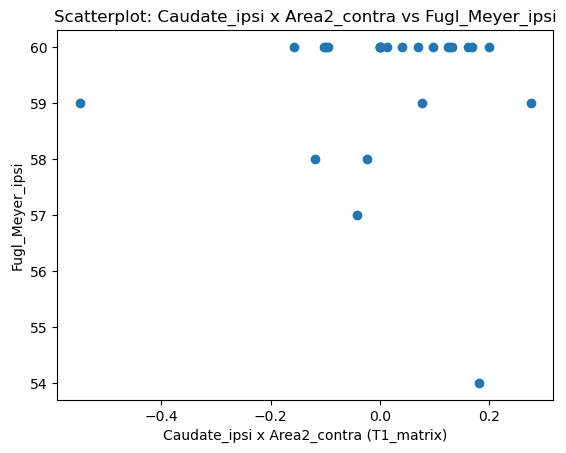

Pearson r = -0.033, p = 0.877


In [ ]:
subject_ids = df_aligned["subject_id"].values
fugl_meyer_ipsi = regression_T1[regression_T1["subject_id"].isin(subject_ids)]["Fugl_Meyer_ipsi"].to_numpy()

plt.scatter(caudate_ipsi_area2_contra, fugl_meyer_ipsi)
plt.xlabel("Caudate_ipsi x Area2_contra (T1_matrix)")
plt.ylabel("Fugl_Meyer_ipsi")
plt.title("Scatterplot: Caudate_ipsi x Area2_contra vs Fugl_Meyer_ipsi")
plt.show()

r, p = pearsonr(caudate_ipsi_area2_contra, fugl_meyer_ipsi)
print(f"Pearson r = {r:.3f}, p = {p:.3f}")

# Compute linear regression
slope, intercept, r_value, p_value, std_err = linregress(caudate_ipsi_area2_contra, fugl_meyer_ipsi)

# Generate points for the regression line
x_vals = np.linspace(min(caudate_ipsi_area2_contra), max(caudate_ipsi_area2_contra), 100)
y_vals = slope * x_vals + intercept

# Create scatter plot with regression line
plt.figure(figsize=(6, 5))
plt.scatter(caudate_ipsi_area2_contra, fugl_meyer_ipsi, label="Subjects")
plt.plot(x_vals, y_vals, color='red', label=f"r = {r_value:.2f}, p = {p_value:.3f}")
plt.xlabel("Caudate_ipsi x Area2_contra (T1_matrix)")
plt.ylabel("Fugl_Meyer_ipsi")
plt.title("Scatterplot: Caudate_ipsi x Area2_contra vs Fugl_Meyer_ipsi")
plt.legend()
plt.tight_layout()
plt.show()


Pearson r = 0.723, p = 0.000


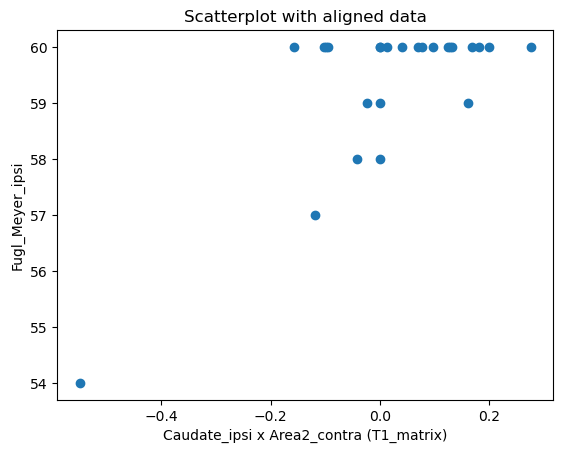

In [ ]:
functions.check_corr(regression_T1, "Caudate_ipsi", "Area_2_contra", "Fugl_Meyer_ipsi", tp=3, corr_type='pearsonr')

Even though there is a plateau, we see something !! => but unaffected hand ...

## nmf motor spearman 

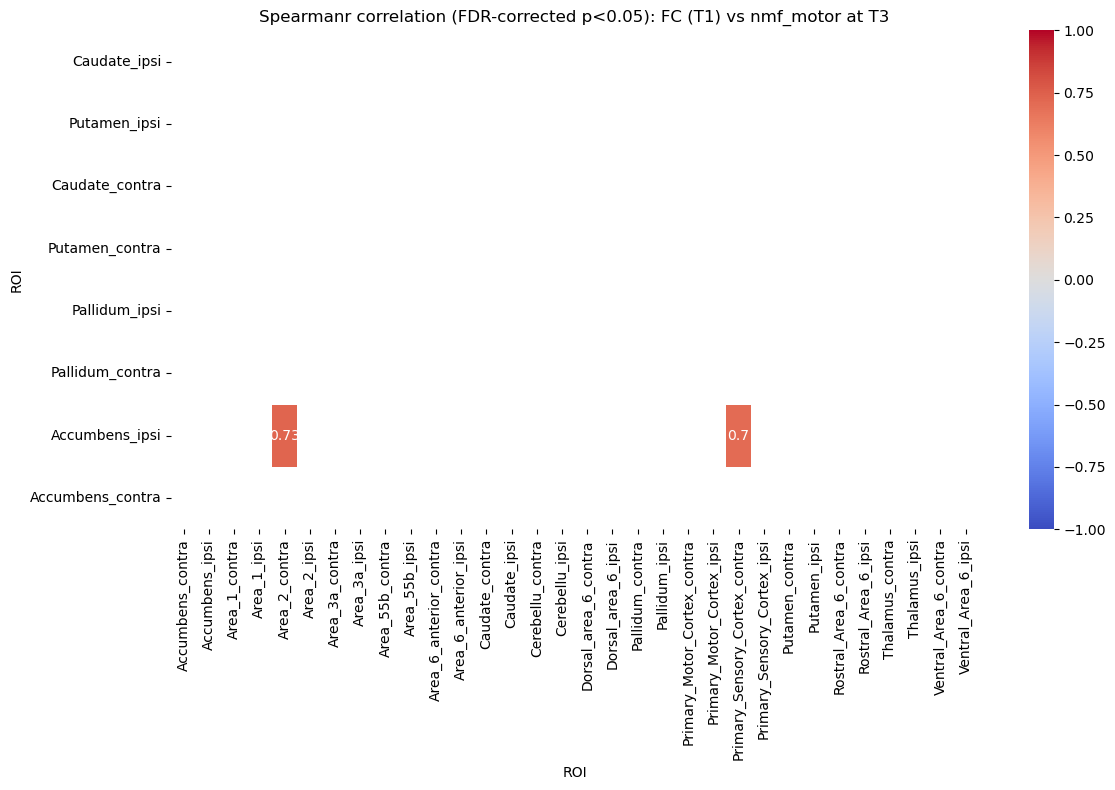

In [33]:
corr, pval, pval_corr = functions.motor_correlation(
    df_aligned,                   # DataFrame with subject_id and T1_matrix (named ROIs)
    regression_info,              # Behavioral data
    tp=3,
    motor_test='nmf_motor',
    corr_type='spearmanr',
    selected_rois_labels=striatum_labels,    # or a custom subset of labels
    mask_significant_only=True     
)

Spearman r = 0.728, p = 0.000


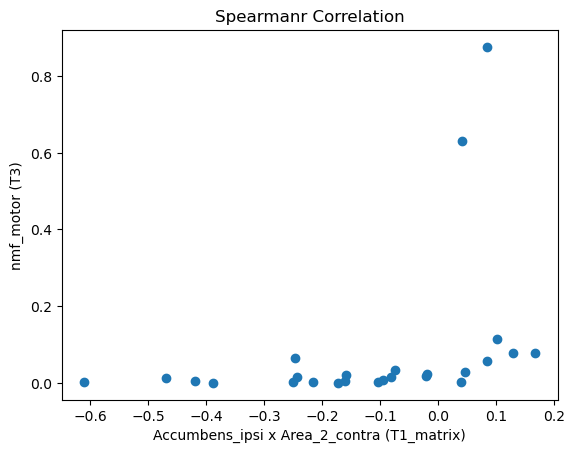

In [ ]:
'''# Step 1: Filter regression info to T1 and matching conditions
regression_T1 = regression_info[
    (regression_info["TimePoint"] == "T3") &
    (regression_info["Behavioral_assessment"] == 1) &
    (regression_info["MRI"] == 1)
].copy()

# Step 2: Merge to ensure alignment
merged = df_aligned.merge(regression_T1[["subject_id", "nmf_motor"]], on="subject_id")

# Step 3: Extract FC values for Caudate_ipsi x Area_2_contra
fc_values = merged["T1_matrix"].apply(
    lambda mat: mat.loc["Accumbens_ipsi", "Area_2_contra"] if "Accumbens_ipsi" in mat.index and "Area_2_contra" in mat.columns else np.nan
).to_numpy()

fugl_meyer_values = merged["nmf_motor"].to_numpy()

# Step 4: Clean data and correlate
valid = ~np.isnan(fc_values) & ~np.isnan(fugl_meyer_values)
r, p = spearmanr(fc_values[valid], fugl_meyer_values[valid])
print(f"spearman r = {r:.3f}, p = {p:.3f}")

# Optional: Plot
plt.scatter(fc_values[valid], fugl_meyer_values[valid])
plt.xlabel("Accumbens_ipsi x Area2_contra (T1_matrix)")
plt.ylabel("nmf_motor (T3)")
plt.title("Scatterplot with aligned data")
plt.show()'''

functions.check_corr(df_aligned, regression_T1, "Accumbens_ipsi", "Area_2_contra", tp=3, motor_test='nmf_motor', corr_type='spearmanr')


In [40]:
df_aligned.T1_matrix.iloc[0]

,Caudate_ipsi,Putamen_ipsi,Pallidum_ipsi,Accumbens_ipsi,Cerebellu_ipsi,Thalamus_ipsi,Area_55b_ipsi,Dorsal_area_6_ipsi,Ventral_Area_6_ipsi,Rostral_Area_6_ipsi,...,Area_55b_contra,Dorsal_area_6_contra,Ventral_Area_6_contra,Rostral_Area_6_contra,Area_6_anterior_contra,Primary_Motor_Cortex_contra,Primary_Sensory_Cortex_contra,Area_1_contra,Area_2_contra,Area_3a_contra
Caudate_ipsi,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Putamen_ipsi,0.0,NaN,0.564233,-0.439911,0.195786,0.283560,0.168873,-0.301750,0.075415,0.011293,...,0.229239,-0.348552,0.088609,-0.084069,-0.018256,-0.291102,-0.318928,-0.423984,-0.301143,-0.311245
Pallidum_ipsi,0.0,0.564233,NaN,-0.166077,-0.014801,0.099974,0.065559,-0.167308,0.004562,-0.033404,...,-0.063119,-0.175806,0.103027,-0.167146,-0.020516,-0.072714,-0.113782,-0.166450,-0.075402,-0.093217
Accumbens_ipsi,0.0,-0.439911,-0.166077,NaN,-0.313404,-0.420605,-0.265260,0.075889,-0.446656,-0.390191,...,-0.425936,-0.012052,-0.118538,-0.241961,-0.208034,0.189921,0.244391,0.256807,0.083569,0.313875
Cerebellu_ipsi,0.0,0.195786,-0.014801,-0.313404,NaN,0.412981,0.117759,-0.060132,0.099763,0.125140,...,0.306218,-0.013615,-0.115914,0.164217,0.177010,-0.247504,-0.239871,-0.127975,0.043830,-0.258970
Thalamus_ipsi,0.0,0.283560,0.099974,-0.420605,0.412981,NaN,0.247364,-0.025616,0.282397,0.322949,...,0.278870,-0.022421,0.236659,0.080968,-0.017097,0.027334,0.000479,-0.077087,-0.077249,-0.157429
Area_55b_ipsi,0.0,0.168873,0.065559,-0.265260,0.117759,0.247364,NaN,0.172745,0.588089,0.312130,...,0.628856,0.046653,0.214639,0.187408,0.107191,0.028133,-0.126044,-0.145072,-0.047493,-0.155359
Dorsal_area_6_ipsi,0.0,-0.301750,-0.167308,0.075889,-0.060132,-0.025616,0.172745,NaN,0.531103,0.468785,...,-0.082838,0.867113,0.090335,0.484720,0.556377,0.294746,0.246041,0.659425,0.757842,0.209763
Ventral_Area_6_ipsi,0.0,0.075415,0.004562,-0.446656,0.099763,0.282397,0.588089,0.531103,NaN,0.815317,...,0.385306,0.452727,0.483504,0.753456,0.423246,0.129090,0.058021,0.188563,0.359187,-0.049383
Rostral_Area_6_ipsi,0.0,0.011293,-0.033404,-0.390191,0.125140,0.322949,0.312130,0.468785,0.815317,NaN,...,0.253823,0.481317,0.109151,0.783374,0.531848,0.196365,0.044793,0.319647,0.432947,-0.045759


Spearman r = 0.705, p = 0.000


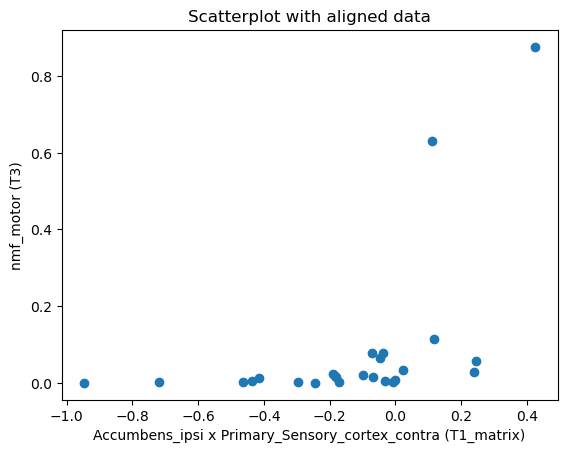

array([ 0.24439128, -0.18120058,  0.11669659, -0.18209134,  0.23997401,
       -0.43608895, -0.07006641, -0.03103968, -0.29582152, -0.46377796,
        0.02317963, -0.24543948, -0.17219126, -0.94706648, -0.18880963,
       -0.04585588, -0.00100288, -0.0369013 , -0.09708175,  0.42498244,
       -0.00670572, -0.71912681,  0.11302604, -0.4149095 , -0.0682018 ])

In [50]:
# Step 1: Filter regression info to T1 and matching conditions
regression_T1 = regression_info[
    (regression_info["TimePoint"] == "T3") &
    (regression_info["Behavioral_assessment"] == 1) &
    (regression_info["MRI"] == 1)
].copy()

# Step 2: Merge to ensure alignment
merged = df_aligned.merge(regression_T1[["subject_id", "nmf_motor"]], on="subject_id")

# Step 3: Extract FC values for Caudate_ipsi x Area_2_contra
fc_values = merged["T1_matrix"].apply(
    lambda mat: mat.loc["Accumbens_ipsi", "Primary_Sensory_Cortex_contra"] if "Accumbens_ipsi" in mat.index and "Primary_Sensory_Cortex_contra" in mat.columns else np.nan
).to_numpy()

fugl_meyer_values = merged["nmf_motor"].to_numpy()

# Step 4: Clean data and correlate
valid = ~np.isnan(fc_values) & ~np.isnan(fugl_meyer_values)
r, p = spearmanr(fc_values[valid], fugl_meyer_values[valid])
print(f"Spearman r = {r:.3f}, p = {p:.3f}")

# Optional: Plot
plt.scatter(fc_values[valid], fugl_meyer_values[valid])
plt.xlabel("Accumbens_ipsi x Primary_Sensory_cortex_contra (T1_matrix)")
plt.ylabel("nmf_motor (T3)")
plt.title("Scatterplot with aligned data")
plt.show()
fc_values